## ML - Assignment 2: TMDB Box Office Prediction

*Submitted by: <br>
Arja Sivapiragasam, Arisa Seljestokken & Raida Talukdar*

### General information / problem

Skriver problemstillingen vår her

### Imports

In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
from datetime import datetime
import json
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
warnings.filterwarnings("ignore")
import ast
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

### Data loading and overview

In [3]:
# a function that reads all the data from a csv
# file to a DataFrame

train_set = pd.read_csv('data/train.csv')
test_set = pd.read_csv('data/test.csv')
train = train_set.copy()
test = test_set.copy()

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
id                       4398 non-null int64
belongs_to_collection    877 non-null object
budget                   4398 non-null int64
genres                   4382 non-null object
homepage                 1420 non-null object
imdb_id                  4398 non-null object
original_language        4398 non-null object
original_title           4398 non-null object
overview                 4384 non-null object
popularity               4398 non-null float64
poster_path              4397 non-null object
production_companies     4140 non-null object
production_countries     4296 non-null object
release_date             4397 non-null object
runtime                  4394 non-null float64
spoken_languages         4356 non-null object
status                   4396 non-null object
tagline                  3535 non-null object
title                    4395 non-null object
Keywords            

The training set has 23 columns, whereas the test set has only 22 columns because it does not have the revenue column. 

Most of the datatypes are objects and should be converted because the desired datatype is int64.

## Kommentarer:

#### Predict:
    * revenue

#### Disse vil vi fokusere på:
    * budget (Arja), imputer
    * genre (Arja/Raida), multilable binariser
    * popularity, gjøre om til int
    * runtime, gjøre om til int


#### Disse vil vi erstatte:
    * homepage
    * belongs_to_collection
    * og_language
    
    
    
#### Disse vil vi droppe:
    * poster_path
    * imdb_id
    * status
    * overview
    * title
    * crew
    
    
    
#### Disse vil vi undersøke mer:
    * og_title
    * release_date
    * prod_companies, multilabel binariser?, one hot encoding
    * prod_countries (Arja), multilabel binariser?
    * spoken_languages, length of array
    * tagline
    * keywords
    * cast, lengde på array, se på korrelasjonen
 
 

In [6]:
# The columns that are choosen below are objects containing text

dict_columns = ['genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

# The following function converts text to dictionaries

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x:
              {} if pd.isna(x) else ast.literal_eval(x) )
    return df

train = text_to_dict(train)
test = text_to_dict(test)

In [7]:
# returns the the first n rows of the data

train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [8]:
test.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,...,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,...,"[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."


In [9]:
train.shape, test.shape

((3000, 23), (4398, 22))

Kommentere...

## Analyzing data

We will now look at some of the most significant attributes from the datasets, and use the various types of values to predict the revenue.

In [10]:
train.isnull().sum().sort_values(ascending=False)

belongs_to_collection    2396
homepage                 2054
tagline                   597
overview                    8
runtime                     2
poster_path                 1
revenue                     0
popularity                  0
budget                      0
genres                      0
imdb_id                     0
original_language           0
original_title              0
production_companies        0
crew                        0
production_countries        0
release_date                0
spoken_languages            0
status                      0
title                       0
Keywords                    0
cast                        0
id                          0
dtype: int64

This list shows the number of missing values for each attribute in descending order.



Because belongs_to_collection and homepage contains the most numbers of missing values, we will use one hot encoding to analyze and decide how much impact these features will have on the revenue. 

These attrbiutes are useful because ......

The training set before we add and remove useful attributes:

In [11]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


### belongs_to_collection and homepage:

belongs_to_collection tells us which movies are in collections, and homepage tells us which movie has a homepage.

In [12]:
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1

test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1

In [13]:
# train['has_collection'] = train['belongs_to_collection'].apply(lambda x: 0 if x.isnull() == False else 1)

train['has_collection'] = 0
train.loc[train['belongs_to_collection'].isnull() == False, 'has_collection'] = 1

test['has_collection'] = 0
test.loc[test['belongs_to_collection'].isnull() == False, 'has_collection'] = 1

#test['has_collection'] = test['belongs_to_collection'].apply(lambda x: 0 if x == {} else 1)

In [14]:
train.head()   # skal fjernes

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,has_homepage,has_collection
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,0,1
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,0,1
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,1,0
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,1,0
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,0,0


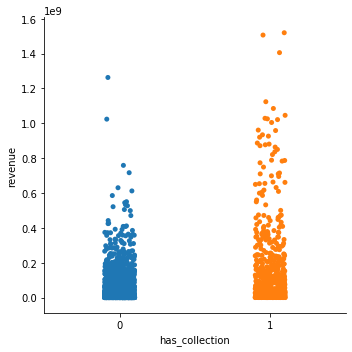

In [15]:
sns.catplot(x="has_collection", y="revenue",data=train)
plt.show()

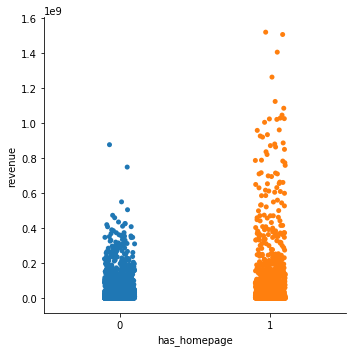

In [16]:
sns.catplot(x="has_homepage", y="revenue",data=train)
plt.show()

The has_collection plot shows that ....

The has_homepage plot shows that ...

We have now made a new attribute has_collection, which means we can drop belongs_to_collection.

We decided to do the same for homepage as well.

In [17]:
train.drop(columns=['belongs_to_collection', 'homepage'], axis =1, inplace=True)
test.drop(columns=['belongs_to_collection', 'homepage'], axis =1, inplace=True)

We have decided to drop the columns poster_path, imdb_id, status, overview, title and crew because we chose to assume they will have no impact on revenue, or because the data is to complex to analyze.

In [18]:
train.drop(columns=['poster_path', 'imdb_id', 'status', 'overview', 'title', 'crew'], axis =1, inplace=True)
test.drop(columns=['poster_path', 'imdb_id', 'status', 'overview', 'title', 'crew'], axis =1, inplace=True)

Let's take a look at the missing values again:

In [19]:
train.isnull().sum().sort_values(ascending=False)

tagline                 597
runtime                   2
has_collection            0
production_companies      0
budget                    0
genres                    0
original_language         0
original_title            0
popularity                0
release_date              0
production_countries      0
has_homepage              0
spoken_languages          0
Keywords                  0
cast                      0
revenue                   0
id                        0
dtype: int64

### original_language:

original_language tells us which original language the movie has. This can be useful because ....

We take a look at the original_language attribute:

In [20]:
train['original_language'].describe()

count     3000
unique      36
top         en
freq      2575
Name: original_language, dtype: object

In [21]:
train['original_language']

0       en
1       en
2       en
3       hi
4       ko
        ..
2995    en
2996    sv
2997    en
2998    en
2999    en
Name: original_language, Length: 3000, dtype: object

Kommentar: ...

A LabelEncoder can be used to make a new fitting attribute:

In [22]:
encoder = LabelEncoder()
og_language = train['original_language']
og_language_encoded = encoder.fit_transform(og_language)
og_language_encoded

encoder2 = LabelEncoder()
og_language_test = test['original_language']
og_language_encoded_test = encoder2.fit_transform(og_language_test)
og_language_encoded_test

array([19,  9,  9, ...,  9,  9, 12])

In [23]:
encoder.classes_

array(['ar', 'bn', 'cn', 'cs', 'da', 'de', 'el', 'en', 'es', 'fa', 'fi',
       'fr', 'he', 'hi', 'hu', 'id', 'it', 'ja', 'ko', 'ml', 'mr', 'nb',
       'nl', 'no', 'pl', 'pt', 'ro', 'ru', 'sr', 'sv', 'ta', 'te', 'tr',
       'ur', 'vi', 'zh'], dtype=object)

Kommentar: .....

In [24]:
train['og_language'] = og_language_encoded
test['og_language'] = og_language_encoded_test
train.head()  # skal fjernes

,id,budget,genres,original_language,original_title,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,tagline,Keywords,cast,revenue,has_homepage,has_collection,og_language
0,1,14000000,"[{'id': 35, 'name': 'Comedy'}]",en,Hot Tub Time Machine 2,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The Laws of Space and Time are About to be Vio...,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651,0,1,7
1,2,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,The Princess Diaries 2: Royal Engagement,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",It can take a lifetime to find true love; she'...,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...",95149435,0,1,7
2,3,3300000,"[{'id': 18, 'name': 'Drama'}]",en,Whiplash,64.299990,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The road to greatness can take you to the edge.,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...",13092000,1,0,7
3,4,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",hi,Kahaani,3.174936,{},"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",NaN,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...",16000000,1,0,13
4,5,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",ko,마린보이,1.148070,{},"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",NaN,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...",3923970,0,0,18


We can now drop the original_language attribute:

In [25]:
train.drop(columns=['original_language'], axis =1, inplace=True)
test.drop(columns=['original_language'], axis =1, inplace=True)

In [26]:
train.head()  # skal fjernes

,id,budget,genres,original_title,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,tagline,Keywords,cast,revenue,has_homepage,has_collection,og_language
0,1,14000000,"[{'id': 35, 'name': 'Comedy'}]",Hot Tub Time Machine 2,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The Laws of Space and Time are About to be Vio...,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651,0,1,7
1,2,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",The Princess Diaries 2: Royal Engagement,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",It can take a lifetime to find true love; she'...,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...",95149435,0,1,7
2,3,3300000,"[{'id': 18, 'name': 'Drama'}]",Whiplash,64.299990,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The road to greatness can take you to the edge.,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...",13092000,1,0,7
3,4,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",Kahaani,3.174936,{},"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",NaN,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...",16000000,1,0,13
4,5,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",마린보이,1.148070,{},"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",NaN,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...",3923970,0,0,18


### Genres:

In [27]:
for i, e in enumerate(train['genres'][:5]):
    print(i, e)

0 [{'id': 35, 'name': 'Comedy'}]
1 [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
2 [{'id': 18, 'name': 'Drama'}]
3 [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
4 [{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]


In [28]:
print('Number of genres in films:')
train['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of genres in films:


2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: genres, dtype: int64

In [29]:
list_of_genres = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [30]:
Counter([i for j in list_of_genres for i in j]).most_common()

[('Drama', 1531),
 ('Comedy', 1028),
 ('Thriller', 789),
 ('Action', 741),
 ('Romance', 571),
 ('Crime', 469),
 ('Adventure', 439),
 ('Horror', 301),
 ('Science Fiction', 290),
 ('Family', 260),
 ('Fantasy', 232),
 ('Mystery', 225),
 ('Animation', 141),
 ('History', 132),
 ('Music', 100),
 ('War', 100),
 ('Documentary', 87),
 ('Western', 43),
 ('Foreign', 31),
 ('TV Movie', 1)]

### production_companies:

In [31]:
for i, e in enumerate(train['production_companies'][:5]):
    print(i, e)

0 [{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
1 [{'name': 'Walt Disney Pictures', 'id': 2}]
2 [{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
3 {}
4 {}


In [32]:
#list_prod_comp = train['production_companies'].apply(lambda x: len(x) if x != {} else 0).value_counts()
#list_prod_comp_test = test['production_companies'].apply(lambda x: len(x) if x != {} else 0).value_counts()

In [33]:
# creates a list of only the prod_comp names for each movie
list_prod_comp = list(train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
list_prod_comp

list_prod_comp_test = list(test['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
list_prod_comp_test

[[],
 ['Woolner Brothers Pictures Inc.'],
 ['Warner Bros.', 'Outlaw Productions (I)', 'Miramax'],
 ['TS Productions', 'Micro scope', 'Phi Group'],
 [],
 ['Castle Rock Entertainment', 'Detour Filmproduction'],
 ['X-Filme Creative Pool',
  'ARTE',
  'Westdeutscher Rundfunk (WDR)',
  'ARD Degeto Film'],
 ['Walt Disney Pictures'],
 ['Ecosse Films', '2 Entertain', 'Bueprint Pictures'],
 ['Pixar Animation Studios'],
 ['Primetime Pictures', 'Emergence Entertainment'],
 ['Canal+',
  'Arte France',
  'Arte France Cinéma',
  'Hold Up Films',
  'Ciné+',
  "Agence Nationale pour la Cohésion Sociale et l'Egalité des Chances (ACSE)",
  'Région Ile-de-France',
  'Fonds Images de la Diversité',
  'Pyramide Distribution',
  'Centre National de la Cinématographie (CNC)',
  'Films Distribution',
  'Lilies Films',
  'Arte / Cofinova 9'],
 ['CAT Films', 'Mimosa Films'],
 [],
 ['The Weinstein Company', 'Summit Entertainment', 'Endgame Entertainment'],
 ['First Point Entertainment', 'Braeburn Entertainment']

In [34]:
Counter([i for j in list_prod_comp for i in j]).most_common()
Counter([i for j in list_prod_comp_test for i in j]).most_common()

[('Warner Bros.', 289),
 ('Universal Pictures', 275),
 ('Paramount Pictures', 232),
 ('Twentieth Century Fox Film Corporation', 203),
 ('Columbia Pictures', 145),
 ('Metro-Goldwyn-Mayer (MGM)', 123),
 ('New Line Cinema', 123),
 ('Touchstone Pictures', 95),
 ('Walt Disney Pictures', 85),
 ('Canal+', 84),
 ('Columbia Pictures Corporation', 79),
 ('TriStar Pictures', 68),
 ('Relativity Media', 67),
 ('Miramax Films', 64),
 ('United Artists', 61),
 ('Village Roadshow Pictures', 53),
 ('DreamWorks SKG', 51),
 ('Regency Enterprises', 50),
 ('Amblin Entertainment', 45),
 ('Lionsgate', 40),
 ('Fox Searchlight Pictures', 40),
 ('Summit Entertainment', 37),
 ('StudioCanal', 37),
 ('Dimension Films', 37),
 ('Working Title Films', 33),
 ('Orion Pictures', 32),
 ('Imagine Entertainment', 32),
 ('Dune Entertainment', 32),
 ('Film4', 31),
 ('Hollywood Pictures', 31),
 ('The Weinstein Company', 30),
 ('New Regency Pictures', 28),
 ('DreamWorks Animation', 28),
 ('Lions Gate Films', 28),
 ('Scott Free 

In [35]:
# converting to numbers
multilabel_binarizer = MultiLabelBinarizer()
prod_comp_encoded = multilabel_binarizer.fit_transform(list_prod_comp)

In [36]:
multilabel_binarizer_test = MultiLabelBinarizer()
prod_comp_encoded_test = multilabel_binarizer_test.fit_transform(list_prod_comp_test)
prod_comp_encoded_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [37]:
np.set_printoptions(threshold=sys.maxsize)
index_1 = np.where(multilabel_binarizer.classes_ == 'Warner Bros.')
index_2 = np.where(multilabel_binarizer.classes_ == 'Universal Pictures')
index_3 = np.where(multilabel_binarizer.classes_ == 'Paramount Pictures')
print(index_1, index_2, index_3)

top3_prod_comp = [0]*3000

for index, item in enumerate(prod_comp_encoded):
    if item[index_1] == 1 or item[index_2] == 1 or item[index_3] == 1:
        top3_prod_comp[index] = 1
        
top3_prod_comp   

(array([3514], dtype=int64),) (array([3403], dtype=int64),) (array([2458], dtype=int64),)


[1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,


In [38]:
np.set_printoptions(threshold=sys.maxsize)
index1 = np.where(multilabel_binarizer_test.classes_ == 'Warner Bros.')
index2 = np.where(multilabel_binarizer_test.classes_ == 'Universal Pictures')
index3 = np.where(multilabel_binarizer_test.classes_ == 'Paramount Pictures')
print(index_1, index_2, index_3)

top3_prod_comp_test = [0]*4398

for index, item in enumerate(prod_comp_encoded_test):
    if item[index1] == 1 or item[index2] == 1 or item[index3] == 1:
        top3_prod_comp_test[index] = 1
        
top3_prod_comp_test   

(array([3514], dtype=int64),) (array([3403], dtype=int64),) (array([2458], dtype=int64),)


[0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,


In [39]:
train['top3_prod_comp'] = top3_prod_comp
test['top3_prod_comp'] = top3_prod_comp_test

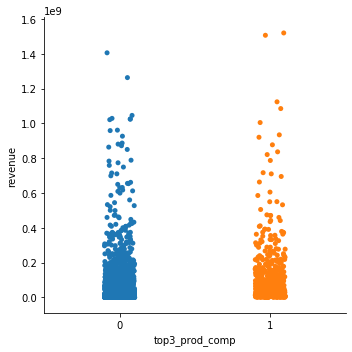

In [40]:
sns.catplot(x="top3_prod_comp", y="revenue",data=train)
plt.show()

In [41]:
train.drop(columns=['production_companies'], axis =1, inplace=True)
test.drop(columns=['production_companies'], axis =1, inplace=True)

In [42]:
### genres

In [43]:
list_genres_train = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
list_genres_test = list(test['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)


In [44]:
multilabel_binarizer_test = MultiLabelBinarizer()
multilabel_binarizer_train = MultiLabelBinarizer()

genre_encoded = multilabel_binarizer_train.fit_transform(list_genres_train)
genre_encoded_test = multilabel_binarizer_test.fit_transform(list_genres_test)

In [45]:
df_multilabel_data_train = pd.DataFrame(genre_encoded, columns=multilabel_binarizer_train.classes_)
df_multilabel_data_test = pd.DataFrame(genre_encoded_test, columns=multilabel_binarizer_test.classes_)
train[multilabel_binarizer_train.classes_] = df_multilabel_data_train
test[multilabel_binarizer_test.classes_] = df_multilabel_data_test
train.head()

,id,budget,genres,original_title,popularity,production_countries,release_date,runtime,spoken_languages,tagline,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,1,14000000,"[{'id': 35, 'name': 'Comedy'}]",Hot Tub Time Machine 2,6.575393,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The Laws of Space and Time are About to be Vio...,...,0,0,0,0,0,0,0,0,0,0
1,2,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",The Princess Diaries 2: Royal Engagement,8.248895,"[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",It can take a lifetime to find true love; she'...,...,0,0,0,0,1,0,0,0,0,0
2,3,3300000,"[{'id': 18, 'name': 'Drama'}]",Whiplash,64.299990,"[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The road to greatness can take you to the edge.,...,0,0,0,0,0,0,0,0,0,0
3,4,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",Kahaani,3.174936,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",NaN,...,0,0,0,0,0,0,0,1,0,0
4,5,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",마린보이,1.148070,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",NaN,...,0,0,0,0,0,0,0,1,0,0


In [46]:
train.drop(columns=['genres'], axis =1, inplace=True)
test.drop(columns=['genres'], axis =1, inplace=True)

In [47]:
multilabel_binarizer_train.classes_

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western'], dtype=object)

In [48]:
multilabel_binarizer_test.classes_

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'Thriller', 'War', 'Western'], dtype=object)

The test set does not include a movie with the genre TV Movie, and the train set only has one movie belonging to this genre. Therefore we can just remove the TV Movie genre column.

In [49]:
train.drop(columns=['TV Movie'], axis =1, inplace=True)

In [50]:
train.head()

,id,budget,original_title,popularity,production_countries,release_date,runtime,spoken_languages,tagline,Keywords,...,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
0,1,14000000,Hot Tub Time Machine 2,6.575393,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The Laws of Space and Time are About to be Vio...,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...",...,0,0,0,0,0,0,0,0,0,0
1,2,40000000,The Princess Diaries 2: Royal Engagement,8.248895,"[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",It can take a lifetime to find true love; she'...,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...",...,0,0,0,0,0,1,0,0,0,0
2,3,3300000,Whiplash,64.299990,"[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The road to greatness can take you to the edge.,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...",...,0,0,0,0,0,0,0,0,0,0
3,4,1200000,Kahaani,3.174936,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",NaN,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...",...,0,0,0,0,0,0,0,1,0,0
4,5,0,마린보이,1.148070,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",NaN,{},...,0,0,0,0,0,0,0,1,0,0


#### Spoken languages:

In [51]:
for i, e in enumerate(train['spoken_languages'][:5]):
    print(i, e)

0 [{'iso_639_1': 'en', 'name': 'English'}]
1 [{'iso_639_1': 'en', 'name': 'English'}]
2 [{'iso_639_1': 'en', 'name': 'English'}]
3 [{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
4 [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]


In [52]:
print('Number of spoken languages in films:')
train['spoken_languages'].apply(lambda x: len(x)
                        if x != {} else 0).value_counts()

Number of spoken languages in films:


1    2105
2     549
3     216
4      72
5      23
0      20
7       6
6       6
8       2
9       1
Name: spoken_languages, dtype: int64

In [53]:
test['spoken_languages'].apply(lambda x: len(x)
                        if x != {} else 0).value_counts()

1    3121
2     770
3     286
4     106
5      50
0      42
6      19
9       2
8       2
Name: spoken_languages, dtype: int64

In [54]:
list_of_slanguage = list(train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
list_of_slanguage_test = list(test['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [55]:
Counter([i for j in list_of_slanguage for i in j]).most_common()

[('English', 2618),
 ('Français', 288),
 ('Español', 239),
 ('Deutsch', 169),
 ('Pусский', 152),
 ('Italiano', 124),
 ('日本語', 89),
 ('普通话', 68),
 ('हिन्दी', 56),
 ('', 47),
 ('Português', 43),
 ('العربية', 40),
 ('한국어/조선말', 37),
 ('广州话 / 廣州話', 36),
 ('தமிழ்', 27),
 ('Polski', 25),
 ('Magyar', 24),
 ('Latin', 23),
 ('svenska', 22),
 ('ภาษาไทย', 22),
 ('Český', 20),
 ('עִבְרִית', 15),
 ('ελληνικά', 15),
 ('Türkçe', 13),
 ('Dansk', 13),
 ('Nederlands', 10),
 ('فارسی', 10),
 ('Tiếng Việt', 10),
 ('اردو', 8),
 ('Română', 8),
 ('తెలుగు', 7),
 ('Kiswahili', 7),
 ('Norsk', 7),
 ('No Language', 7),
 ('suomi', 6),
 ('Український', 6),
 ('Srpski', 4),
 ('Afrikaans', 4),
 ('Gaeilge', 3),
 ('Català', 3),
 ('বাংলা', 3),
 ('ਪੰਜਾਬੀ', 3),
 ('Somali', 3),
 ('Íslenska', 3),
 ('български език', 2),
 ('shqip', 2),
 ('Bahasa indonesia', 2),
 ('Slovenčina', 2),
 ('Esperanto', 2),
 ('euskera', 2),
 ('isiZulu', 2),
 ('Hrvatski', 2),
 ('қазақ', 1),
 ('Wolof', 1),
 ('Eesti', 1),
 ('پښتو', 1)]

In [56]:
number_of_spoken_language = [0]*3000
number_of_spoken_language_test = [0]*4398

for index, item in enumerate(list_of_slanguage): 
            number_of_spoken_language[index] = len(item)
            
for index, item in enumerate(list_of_slanguage_test): 
            number_of_spoken_language_test[index] = len(item)
    
train['number_of_spoken_languages'] = number_of_spoken_language
test['number_of_spoken_languages'] = number_of_spoken_language_test

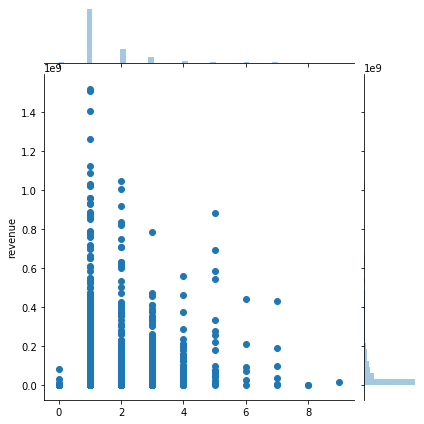

In [57]:
sns.jointplot(number_of_spoken_language, train.revenue);

From plotting the revenue over the number of spoken languages we can deduce that it does have an impact on revenue and there we can include this is our dataframe, and delete the spoken_languages attribute.

In [58]:
train.drop(columns=['spoken_languages'], axis =1, inplace=True)
test.drop(columns=['spoken_languages'], axis =1, inplace=True)

### production_countries

In [59]:
list_prod_countr = list(train['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
list_prod_countr_test = list(test['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [60]:
Counter([i for j in list_prod_countr for i in j]).most_common()

[('United States of America', 2282),
 ('United Kingdom', 380),
 ('France', 222),
 ('Germany', 167),
 ('Canada', 120),
 ('India', 81),
 ('Italy', 64),
 ('Japan', 61),
 ('Australia', 61),
 ('Russia', 58),
 ('Spain', 54),
 ('China', 42),
 ('Hong Kong', 42),
 ('Ireland', 23),
 ('Belgium', 23),
 ('South Korea', 22),
 ('Mexico', 19),
 ('Sweden', 18),
 ('New Zealand', 17),
 ('Netherlands', 15),
 ('Czech Republic', 14),
 ('Denmark', 13),
 ('Brazil', 12),
 ('Luxembourg', 10),
 ('South Africa', 10),
 ('Hungary', 9),
 ('United Arab Emirates', 9),
 ('Austria', 8),
 ('Switzerland', 8),
 ('Romania', 8),
 ('Greece', 7),
 ('Norway', 7),
 ('Argentina', 6),
 ('Chile', 6),
 ('Finland', 6),
 ('Israel', 5),
 ('Turkey', 5),
 ('Iran', 5),
 ('Poland', 5),
 ('Morocco', 3),
 ('Philippines', 3),
 ('Taiwan', 3),
 ('Bulgaria', 3),
 ('Bahamas', 3),
 ('Serbia', 2),
 ('Iceland', 2),
 ('Cambodia', 2),
 ('Malta', 2),
 ('Pakistan', 2),
 ('Qatar', 2),
 ('Tunisia', 2),
 ('Ukraine', 2),
 ('Singapore', 2),
 ('Indonesia', 2)

In [61]:
produced_in_usa = [0]*3000
produced_in_usa_test = [0]*4398

for index, item in enumerate(list_prod_countr):
    for i in item: 
        if i == 'United States of America':
            produced_in_usa[index] = 1

for index, item in enumerate(list_prod_countr_test):
    for i in item: 
        if i == 'United States of America':
            produced_in_usa_test[index] = 1            

In [62]:
train['produced_in_USA'] = produced_in_usa
test['produced_in_USA'] = produced_in_usa_test

In [63]:
train.head()

,id,budget,original_title,popularity,production_countries,release_date,runtime,tagline,Keywords,cast,...,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,number_of_spoken_languages,produced_in_USA
0,1,14000000,Hot Tub Time Machine 2,6.575393,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,The Laws of Space and Time are About to be Vio...,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...",...,0,0,0,0,0,0,0,0,1,1
1,2,40000000,The Princess Diaries 2: Royal Engagement,8.248895,"[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,It can take a lifetime to find true love; she'...,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...",...,0,0,0,1,0,0,0,0,1,1
2,3,3300000,Whiplash,64.299990,"[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,The road to greatness can take you to the edge.,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...",...,0,0,0,0,0,0,0,0,1,1
3,4,1200000,Kahaani,3.174936,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,NaN,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...",...,0,0,0,0,0,1,0,0,2,0
4,5,0,마린보이,1.148070,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,NaN,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...",...,0,0,0,0,0,1,0,0,1,0


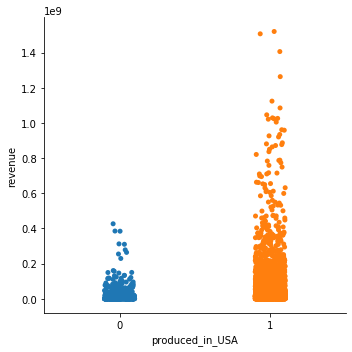

In [64]:
sns.catplot(x="produced_in_USA", y="revenue",data=train)
plt.show()

We can tell from observing this scatter plot that a moving being produced in the US has a significant impact on revenue. We can now delete the old production_countries attribute. 

In [65]:
train.drop(columns=['production_countries'], axis =1, inplace=True)
test.drop(columns=['production_countries'], axis =1, inplace=True)

In [66]:
test.head()

,id,budget,original_title,popularity,release_date,runtime,tagline,Keywords,cast,has_homepage,...,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,number_of_spoken_languages,produced_in_USA
0,3001,0,ディアルガVSパルキアVSダークライ,3.851534,7/14/07,90.0,Somewhere Between Time & Space... A Legend Is ...,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...",1,...,0,0,0,0,0,0,0,0,2,1
1,3002,88000,Attack of the 50 Foot Woman,3.559789,5/19/58,65.0,A titanic beauty spreads a macabre wave of hor...,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...",0,...,1,0,0,0,1,0,0,0,1,1
2,3003,0,Addicted to Love,8.085194,5/23/97,100.0,A Comedy About Lost Loves And Last Laughs,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...",0,...,0,0,0,1,0,0,0,0,1,1
3,3004,6800000,Incendies,8.596012,9/4/10,130.0,The search began at the opening of their mothe...,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...",1,...,0,0,1,0,0,0,1,0,3,0
4,3005,2000000,Inside Deep Throat,3.217680,2/11/05,92.0,It was filmed in 6 days for 25 thousand dollar...,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...",0,...,0,0,0,0,0,0,0,0,1,1


In [67]:
train.head()

,id,budget,original_title,popularity,release_date,runtime,tagline,Keywords,cast,revenue,...,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,number_of_spoken_languages,produced_in_USA
0,1,14000000,Hot Tub Time Machine 2,6.575393,2/20/15,93.0,The Laws of Space and Time are About to be Vio...,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651,...,0,0,0,0,0,0,0,0,1,1
1,2,40000000,The Princess Diaries 2: Royal Engagement,8.248895,8/6/04,113.0,It can take a lifetime to find true love; she'...,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...",95149435,...,0,0,0,1,0,0,0,0,1,1
2,3,3300000,Whiplash,64.299990,10/10/14,105.0,The road to greatness can take you to the edge.,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...",13092000,...,0,0,0,0,0,0,0,0,1,1
3,4,1200000,Kahaani,3.174936,3/9/12,122.0,NaN,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...",16000000,...,0,0,0,0,0,1,0,0,2,0
4,5,0,마린보이,1.148070,2/5/09,118.0,NaN,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...",3923970,...,0,0,0,0,0,1,0,0,1,0


# ARISA UPDATE 6 NOVEMBER 23:04

**Tagline**

In [68]:
train['has_tagline'] = 0
train.loc[train['tagline'].isnull() == False, 'has_tagline'] = 1

test['has_tagline'] = 0
test.loc[test['tagline'].isnull() == False, 'has_tagline'] = 1

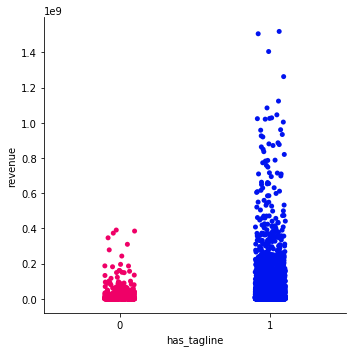

In [69]:
has_tagline_palette = ['#ef0067','#0013ef']
sns.set_palette(has_tagline_palette)
sns.catplot(x="has_tagline", y="revenue", data=train)
plt.show()

We see the same observation as belongs_to_collection and has_homepage in movies with and without taglines as well.

In [70]:
train.drop(columns=['tagline'], axis=1, inplace=True)
test.drop(columns=['tagline'], axis=1, inplace=True)

**Release date**

In [71]:
# Convert from object type to pandas datetime type
train['release_date'] = pd.to_datetime(train['release_date'])
test['release_date'] = pd.to_datetime(test['release_date'])

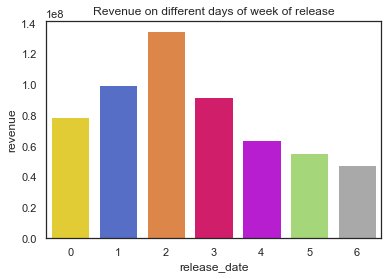

In [72]:
# Styling
release_day_palette = ['#ffe119','#4363d8','#f58231','#ef0067','#cd00ed','#a4e56b','#a9a9a9']
sns.set(style="white")
# Pandas dataframe.sort_index() function sorts objects by labels along the given axis
release_day = train['release_date'].value_counts().sort_index()
# Pandas .groupby function groups DataFrame by using a mapper or by a series of columns
release_day_revenue = train.groupby(['release_date'])['revenue'].sum()
release_day_revenue.index = release_day_revenue.index.dayofweek #day_name()
sns.barplot(release_day_revenue.index, release_day_revenue, data = train, palette = release_day_palette, ci=0)
plt.title('Revenue on different days of week of release')
plt.show()

| Monday |Tuesday | Wednesday | Thursday | Friday | Saturday| Sunday | 
|--|--|--|--|--|--|--|
|0|1|2|3|4|5|6|

We can see that movies that are released on Wednesdays get the highest revenue compare to the other days. We will now add this new feature into our data.

In [73]:
train['release_day'] = train['release_date'].dt.dayofweek 
test['release_day'] = test['release_date'].dt.dayofweek
# The lines below shows how many movies are released in which day during the week in our data
# pd.DataFrame(training_data_copy.release_day.value_counts()).T
train['release_day'].value_counts()

4    1335
3     609
2     450
1     196
5     158
0     133
6     119
Name: release_day, dtype: int64

We can now drop the feature _release_date_.

In [74]:
train.drop(columns=['release_date'], axis=1, inplace=True)
test.drop(columns=['release_date'], axis=1, inplace=True)

#### Runtime

The runtime feature is of type float64, we want to convert this feature into int64 type. Before doing this, we have to take care of the missing values in this feature. It seems reasonable to replace the missing values by either the mean or median value of all the runtime values. We'll check which one makes most sense to replace the missing values with.

In [75]:
mean_runtime = train['runtime'].mean().astype(int)
median_runtime = train['runtime'].median().astype(int)
print('Mean runtime: ', mean_runtime, '\nMedian runtime: ', median_runtime)

Mean runtime:  107 
Median runtime:  104


There're only two samples with missing values in this feature. We decided to replace these with the mean value after checking both the mean and median value.

In [76]:
# Replace samples with missing values with the mean value
train['runtime'] = train['runtime'].fillna( train['runtime'].mean() )

# Do the same with the test set
test['runtime'] = test['runtime'].fillna( test['runtime'].mean() )

In [77]:
# Check that runtime has none missing values left
train.isnull().sum().sort_values(ascending=False)

release_day                   0
has_homepage                  0
Animation                     0
Adventure                     0
Action                        0
top3_prod_comp                0
og_language                   0
has_collection                0
revenue                       0
Crime                         0
cast                          0
Keywords                      0
runtime                       0
popularity                    0
original_title                0
budget                        0
Comedy                        0
Documentary                   0
has_tagline                   0
Romance                       0
produced_in_USA               0
number_of_spoken_languages    0
Western                       0
War                           0
Thriller                      0
Science Fiction               0
Mystery                       0
Drama                         0
Music                         0
Horror                        0
History                       0
Foreign 

In [78]:
# To drop the samples that have 0.0 as value in the runtime feature I create a new dataset without these samples
train = train[train.runtime != 0.0]

# Do the same with the test set
test = test[test.runtime != 0.0]

In [79]:

# Check that sample with the minimum runtime is not 0.0
min_runtime = min(train['runtime'])
print('Min runtime', min_runtime)

min_runtime_test = min(test['runtime'])
print('Min runtime test', min_runtime_test)

Min runtime 11.0
Min runtime test 25.0


In [80]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4389 entries, 0 to 4397
Data columns (total 34 columns):
id                            4389 non-null int64
budget                        4389 non-null int64
original_title                4389 non-null object
popularity                    4389 non-null float64
runtime                       4389 non-null float64
Keywords                      4389 non-null object
cast                          4389 non-null object
has_homepage                  4389 non-null int64
has_collection                4389 non-null int64
og_language                   4389 non-null int32
top3_prod_comp                4389 non-null int64
Action                        4389 non-null int32
Adventure                     4389 non-null int32
Animation                     4389 non-null int32
Comedy                        4389 non-null int32
Crime                         4389 non-null int32
Documentary                   4389 non-null int32
Drama                         4389 n

In [81]:
test.isnull().sum().sort_values(ascending=False)

release_day                   1
has_collection                0
Comedy                        0
Animation                     0
Adventure                     0
Action                        0
top3_prod_comp                0
og_language                   0
has_homepage                  0
has_tagline                   0
cast                          0
Keywords                      0
runtime                       0
popularity                    0
original_title                0
budget                        0
Crime                         0
Documentary                   0
Drama                         0
Family                        0
Fantasy                       0
Foreign                       0
History                       0
Horror                        0
Music                         0
Mystery                       0
Romance                       0
Science Fiction               0
Thriller                      0
War                           0
Western                       0
number_o

In [82]:
# Replace samples with missing values with the mean value
test['release_day'] = test['release_day'].fillna( test['release_day'].mean() )

## Skjønner ikke helt hvorfor NaN er ikke blitt erstattet med gjennomsnittverdien. Skal se på dette i morgen 😄

In [83]:
train.head()

,id,budget,original_title,popularity,runtime,Keywords,cast,revenue,has_homepage,has_collection,...,Mystery,Romance,Science Fiction,Thriller,War,Western,number_of_spoken_languages,produced_in_USA,has_tagline,release_day
0,1,14000000,Hot Tub Time Machine 2,6.575393,93.0,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...",12314651,0,1,...,0,0,0,0,0,0,1,1,1,4
1,2,40000000,The Princess Diaries 2: Royal Engagement,8.248895,113.0,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...",95149435,0,1,...,0,1,0,0,0,0,1,1,1,4
2,3,3300000,Whiplash,64.299990,105.0,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...",13092000,1,0,...,0,0,0,0,0,0,1,1,1,4
3,4,1200000,Kahaani,3.174936,122.0,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...",16000000,1,0,...,0,0,0,1,0,0,2,0,0,4
4,5,0,마린보이,1.148070,118.0,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...",3923970,0,0,...,0,0,0,1,0,0,1,0,0,3


### Data visualization and exploration

#### Plotting budget vs. revenue:

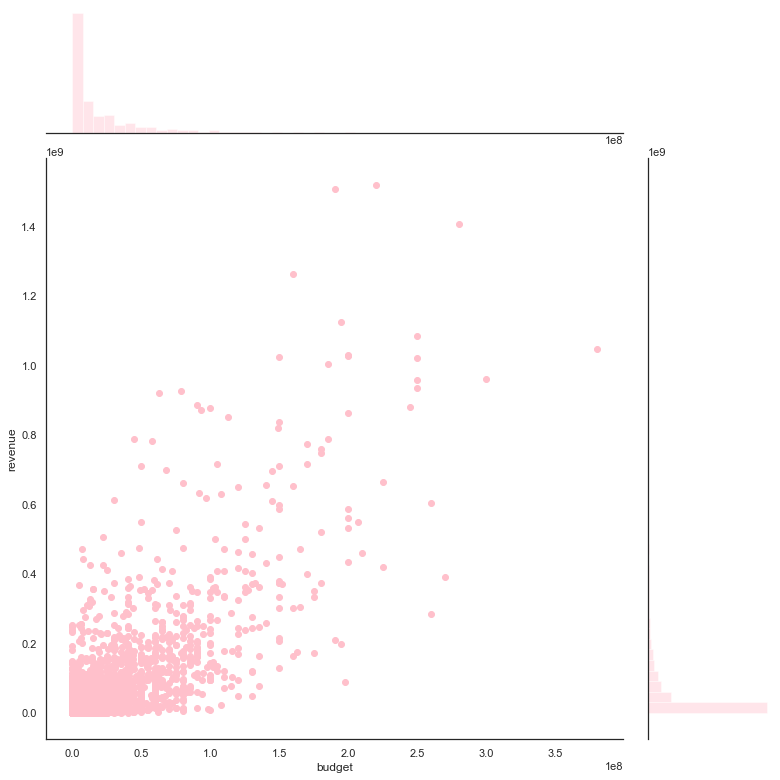

In [84]:
sns.jointplot(x="budget", y="revenue", data=train,
             height=11, ratio=4, color="pink")
plt.show()

#### Plotting popularity vs. revenue:

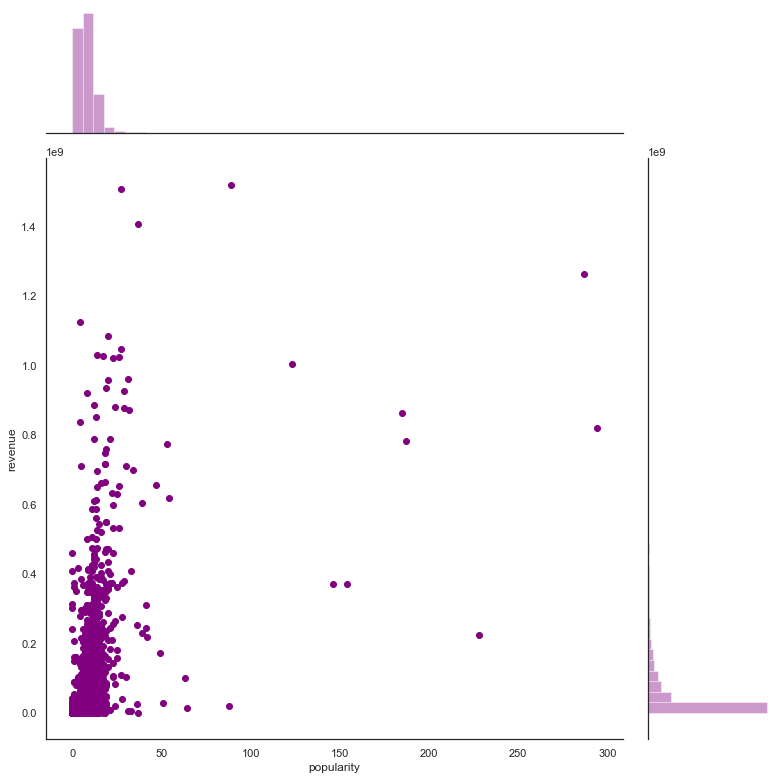

In [176]:
sns.jointplot(x="popularity", y="revenue", data=train,
             height=11, ratio=4, color="purple")
plt.show()

#### Plotting runtime vs. revenue:

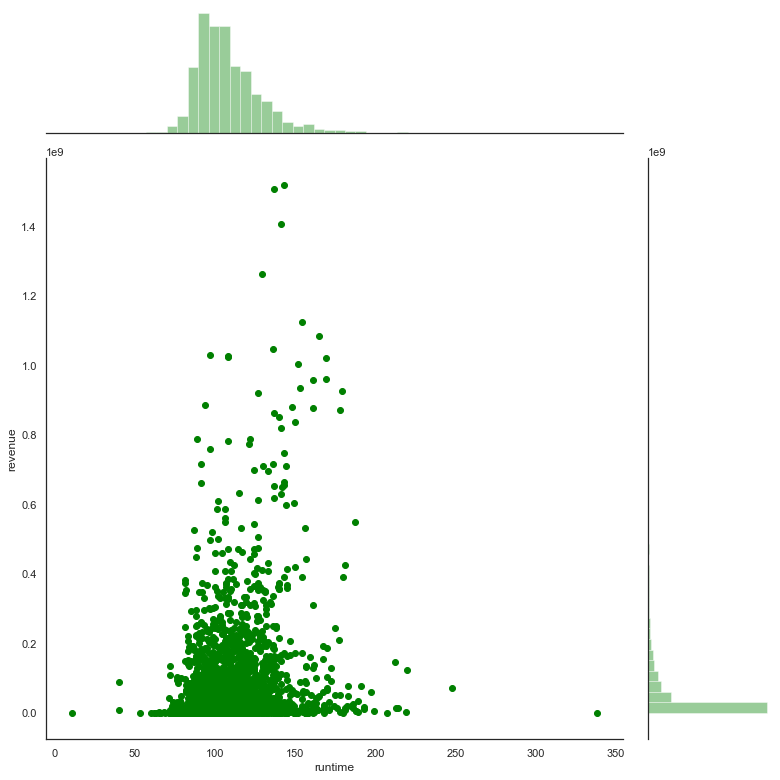

In [86]:
sns.jointplot(x="runtime", y="revenue", data=train,
             height=11, ratio=4, color="green")
plt.show()

#### Revenue (Target Variable) Distribution:

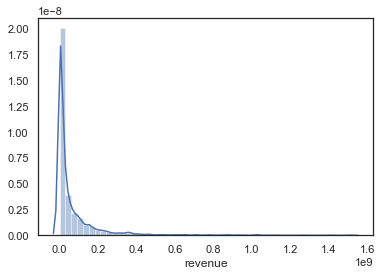

In [87]:
sns.distplot(train.revenue)

In [88]:
train.revenue.describe()

count    2.988000e+03
mean     6.693845e+07
std      1.377606e+08
min      1.000000e+00
25%      2.401550e+06
50%      1.692863e+07
75%      6.911858e+07
max      1.519558e+09
Name: revenue, dtype: float64

Since the revenue-variable is skewed, we are going to 
calculate the log.

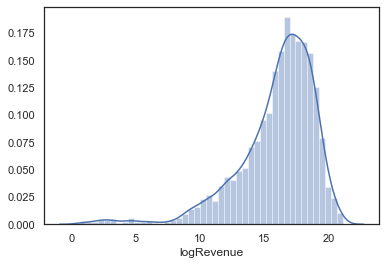

In [89]:

train['logRevenue'] = np.log1p(train['revenue'])
sns.distplot(train['logRevenue'])

#### Calculate release date:

In [90]:
# the last two digits of the date represents the
# year, so this is a way of getting the release year:

train[['release_month','release_day','release_year']]=train['release_date'].str.split('/',expand=True).replace(np.nan, -1).astype(int)

# some rows have 4 digits of release year insted of 2.
# we can use these conditions to fix that problem: 
train.loc[ (train['release_year'] <= 19) & (train['release_year'] < 100), "release_year"] += 2000
train.loc[ (train['release_year'] > 19)  & (train['release_year'] < 100), "release_year"] += 1900

releaseDate = pd.to_datetime(train['release_date']) 

train['release_dayofweek'] = releaseDate.dt.dayofweek



KeyError: 'release_date'

#### Plotting the count of release years:

In [ ]:
plt.figure(figsize=(20,12))
sns.countplot(train['release_year'].sort_values())
plt.title("Movie Release Count by Year", fontsize=20)
loc, labels = plt.xticks()
plt.xticks(fontsize=12, rotation=90)
plt.show()

#### Plotting the count of releases in each month:

In [ ]:
plt.figure(figsize=(20,12))
sns.countplot(train['release_month'].sort_values())
plt.title("Release Month Count",fontsize=20)
loc, labels = plt.xticks()
loc, labels = loc, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(loc, labels,fontsize=20)
plt.show()

#### Plotting release day of the week

In [ ]:
plt.figure(figsize=(20,12))
sns.countplot(train['release_dayofweek'].sort_values())
plt.title("Total movies released on Day Of Week",fontsize=20)
loc, labels = plt.xticks()
loc, labels = loc, ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
plt.xticks(loc, labels,fontsize=20)
plt.show()

#### Plotting the release year vs. revenue:

In [ ]:
train['meanRevenueByYear'] = train.groupby("release_year")["revenue"].aggregate('mean')
train['meanRevenueByYear'].plot(figsize=(15,10),color="g")
plt.xticks(np.arange(1920,2018,6))
plt.xlabel("Release Year")
plt.ylabel("Revenue")
plt.title("Movie Mean Revenue By Year",fontsize=20)
plt.show()

In [ ]:
if False: '''
train['meanRevenueByYear'] = train.groupby("release_year")["revenue"].aggregate('mean')
#train['meanRevenueByYear'].plot(figsize=(15,10),color="g")
#plt.xticks(np.arange(1920,2018,6))
#plt.xlabel("Release Year")
#plt.ylabel("Revenue")
#plt.title("Movie Mean Revenue By Year",fontsize=20)

plt.figure(figsize=(20,12))
sns.countplot(train['release_month'].sort_values())
plt.title("Release Month Count",fontsize=20)

sns.jointplot(data=train, x="Release Year", y="Revenue", title="Movie Mean Revenue By Year",
             height=11, ratio=4, color="pink")

'''

#### Plotting the release month vs. revenue

In [ ]:
train['meanRevenueByMonth'] = train.groupby("release_month")["revenue"].aggregate('mean')
train['meanRevenueByMonth'].plot(figsize=(15,10),color="g")
plt.xlabel("Release Month")
plt.ylabel("Revenue")
plt.title("Movie Mean Revenue Release Month",fontsize=20)
plt.show()

#### Movie Mean Popularity by Year:

In [ ]:
train['meanPopularityByYear'] = train.groupby("release_year")["popularity"].aggregate('mean')
train['meanPopularityByYear'].plot(figsize=(15,10),color="g")
plt.xticks(np.arange(1920,2018,4))
plt.xlabel("Release Year")
plt.ylabel("Popularity")
plt.title("Movie Mean Popularity by Year",fontsize=20)
plt.show()

In [ ]:
if False: '''
d1 = train['release_date'].value_counts().sort_index()
d2 = test['release_date'].value_counts().sort_index()

data = [go.Scatter(x=d1.index, y=d1.values, name='train'),
        go.Scatter(x=d2.index, y=d2.values, name='test')]

layout = go.Layout(dict(title = "Number of films per year",
                       xaxis = dict(title = 'Year'),
                       yaxis = dict(title = 'Count'),),
                   legend=dict(orientation="v"))
py.iplot(dict(data=data, layout=layout))
'''

In [ ]:
train.drop(columns=['logRevenue'], axis=1, inplace=True)

In [91]:
train.corr()

,id,budget,popularity,runtime,revenue,has_homepage,has_collection,og_language,top3_prod_comp,Action,...,Romance,Science Fiction,Thriller,War,Western,number_of_spoken_languages,produced_in_USA,has_tagline,release_day,logRevenue
id,1.000000,0.020363,-0.006715,0.016303,0.000834,-0.005851,-0.011840,-0.015738,-0.018425,0.028351,...,-0.005894,0.026475,-0.014871,-0.005392,-0.022270,-0.005221,0.002695,-0.016688,-0.001432,0.014810
budget,0.020363,1.000000,0.341520,0.239769,0.752855,0.247052,0.223186,-0.120668,0.209133,0.276529,...,-0.090273,0.190069,0.062991,0.020682,-0.009962,0.100742,0.246825,0.215009,-0.117090,0.488100
popularity,-0.006715,0.341520,1.000000,0.128770,0.461051,0.164028,0.156069,-0.102636,0.086800,0.105141,...,-0.053970,0.082363,0.046626,0.018854,0.000736,0.035160,0.150310,0.161547,-0.094691,0.288670
runtime,0.016303,0.239769,0.128770,1.000000,0.219677,0.032925,-0.040679,0.149697,0.081105,0.097027,...,0.059822,-0.040131,0.000397,0.134480,0.064451,0.179298,-0.097322,-0.029563,-0.089966,0.203759
revenue,0.000834,0.752855,0.461051,0.219677,1.000000,0.262887,0.340101,-0.090112,0.176742,0.184769,...,-0.049961,0.134072,0.006802,-0.022997,-0.013252,0.064099,0.196162,0.178777,-0.141893,0.504159
has_homepage,-0.005851,0.247052,0.164028,0.032925,0.262887,1.000000,0.060304,-0.021323,-0.023471,0.040501,...,-0.064071,0.051858,-0.006373,-0.006509,-0.038412,0.060356,0.036058,0.068950,-0.055340,0.145652
has_collection,-0.011840,0.223186,0.156069,-0.040679,0.340101,0.060304,1.000000,0.016058,0.106416,0.183935,...,-0.154361,0.136423,0.063348,-0.014601,-0.045800,0.046392,0.082967,0.113258,-0.044538,0.257705
og_language,-0.015738,-0.120668,-0.102636,0.149697,-0.090112,-0.021323,0.016058,1.000000,-0.116361,0.011507,...,-0.006009,-0.033712,-0.061921,0.065324,-0.023050,0.028441,-0.472671,-0.335096,0.005643,-0.136380
top3_prod_comp,-0.018425,0.209133,0.086800,0.081105,0.176742,-0.023471,0.106416,-0.116361,1.000000,0.078556,...,-0.045219,0.030114,0.057683,-0.016210,0.002078,-0.014115,0.225238,0.164397,-0.013114,0.245128
Action,0.028351,0.276529,0.105141,0.097027,0.184769,0.040501,0.183935,0.011507,0.078556,1.000000,...,-0.177260,0.194850,0.270066,0.070160,0.030392,0.105755,0.035808,0.097123,-0.046797,0.166939


In [128]:
train['popularity'] = train['popularity'].astype(int)
test['popularity'] = test['popularity'].astype(int)
train['runtime'] = train['runtime'].astype(int)
test['runtime'] = test['runtime'].astype(int)
test['release_day'] = test['release_day'].astype(int)

In [129]:
X = train[['budget','runtime', 'has_collection', 'has_homepage', 'has_tagline', 'release_day', 'top3_prod_comp']]
y = train.revenue
#splitting the data into training and validation to check validity of the model

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=1)

#Linear Model
from sklearn.linear_model import LinearRegression, Ridge, Lasso
def rmsle(y,y0): return np.sqrt(np.mean(np.square(np.log1p(y)-np.log1p(y0)))) 
reg = LinearRegression()
lin_model = reg.fit(X_train, y_train)
y_pred = reg.predict(X_val)
print('RMSLE score for linear model is {}'.format(rmsle(y_val, y_pred)))

#Applyting the model on test data and submission
X_test = test[['budget','runtime', 'has_collection', 'has_homepage', 'has_tagline', 'release_day', 'top3_prod_comp']]
pred1 = reg.predict(X_test)


RMSLE score for linear model is 1.9010210708507729


In [266]:
X = train[['budget', 'popularity', 'runtime', 'has_homepage', 'has_collection', 'Adventure',
                  'produced_in_USA', 'has_tagline', ]]
y = train.revenue

In [267]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=1)

#Linear Model
from sklearn.linear_model import LinearRegression, Ridge, Lasso
def rmsle(y,y0): return np.sqrt(np.mean(np.square(np.log1p(y)-np.log1p(y0)))) 
reg = LinearRegression()
lin_model = reg.fit(X_train, y_train)
y_pred = reg.predict(X_val)
print('RMSLE score for linear model is {}'.format(rmsle(y_val, y_pred)))

#Applyting the model on test data and submission
X_test = test[['budget', 'popularity', 'runtime', 'has_homepage', 'has_collection', 'Adventure',
                  'produced_in_USA', 'has_tagline', ]]
pred1 = reg.predict(X_test)

RMSLE score for linear model is 1.644290547476121


In [268]:
from sklearn.ensemble import RandomForestRegressor

#from sklearn.impute import SimpleImputer
#imputer = SimpleImputer(strategy='most_frequent')

#imputer.fit_transform(X)
#imputer.fit_transform(X_test)

def rmsle(y,y0): return np.sqrt(np.mean(np.square(np.log1p(y)-np.log1p(y0))))
y = train.revenue

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=1)

rf = RandomForestRegressor()
rf_model = rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_val)
print('RMSLE score for Random Forest model is {}'.format(rmsle(y_val, rf_y_pred)))
pred3 = rf.predict(X_test)

RMSLE score for Random Forest model is 2.0083608332283607


In [106]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2988 entries, 0 to 2999
Data columns (total 36 columns):
id                            2988 non-null int64
budget                        2988 non-null int64
original_title                2988 non-null object
popularity                    2988 non-null int32
runtime                       2988 non-null int32
Keywords                      2988 non-null object
cast                          2988 non-null object
revenue                       2988 non-null int64
has_homepage                  2988 non-null int64
has_collection                2988 non-null int64
og_language                   2988 non-null int32
top3_prod_comp                2988 non-null int64
Action                        2988 non-null int32
Adventure                     2988 non-null int32
Animation                     2988 non-null int32
Comedy                        2988 non-null int32
Crime                         2988 non-null int32
Documentary                   2988 non-n